# 주요 사안 복습
https://mlu-explain.github.io/
### Recall, Precision
### Bias and Variance Trade off

# 불균형데이터의 예측 성능

In [14]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams['font.family']='Malgun Gothic' # 한글폰트
plt.rcParams['axes.unicode_minus'] = False

import pandas as pd
import numpy as np

from sklearn import preprocessing, model_selection, metrics, pipeline 

! pip install mglearn
! pip install scikit-plot

In [15]:
from sklearn.metrics import precision_recall_curve

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    #plt.rcParams["figure.figsize"] = (8,6)
    plt.rcParams['font.family']='Malgun Gothic' # 한글폰트
    plt.title('cut-off value, (precesion, recall, F1-score, predicted positive rate)', fontsize='16') 
    plt.plot(thresholds, precisions[:-1], 'b-', label='Precision') # 판사
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall') # 검사
    plt.plot(thresholds, (2*precisions[:-1]*recalls[:-1])/(precisions[:-1] +recalls[:-1]), 
             'r-', label='f1 score') # 변호사
    plt.plot(thresholds, scores, 'k--', label='predicted positive rate') # q-ratio
    plt.ylabel('precesion, recall', fontsize='14') 
    plt.xlabel('cut-off value', fontsize='14') 
    plt.legend(loc='best', fontsize='14') 

## **1. PR graph의 중요성**

### 1%의 positive 유형을 갖는 극심한 불균형데이터

In [16]:
plt.rcParams["figure.figsize"] = (8,6)

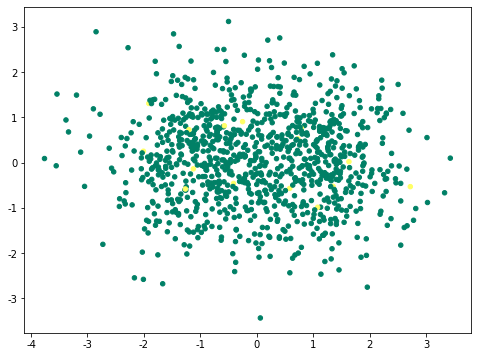

In [45]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_classes=2, weights=[0.99, 0.01],
                          random_state=1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='summer')

In [46]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.5, 
                                                                    random_state = 2, stratify=y)
print(f'Dataset: Class 0(음성)= {len(y[y==0])} 개, Class1(양성)={len(y[y==1])} 개')

Dataset: Class 0(음성)= 985 개, Class1(양성)=15 개


LogisticRegression()

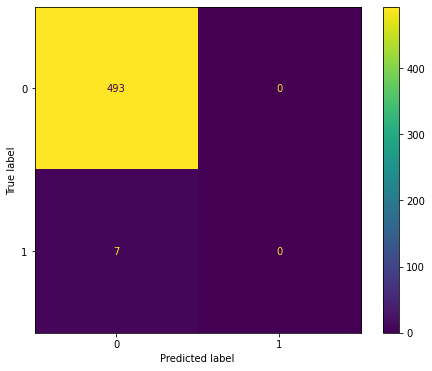

In [47]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

metrics.plot_confusion_matrix(clf, X_test, y_test)

In [48]:
y_probas = clf.fit(X_train, y_train).predict_proba(X_test)

target_names = ['Negative (0)', 'Positive(1)']
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

Negative (0)       0.99      1.00      0.99       493
 Positive(1)       0.00      0.00      0.00         7

    accuracy                           0.99       500
   macro avg       0.49      0.50      0.50       500
weighted avg       0.97      0.99      0.98       500



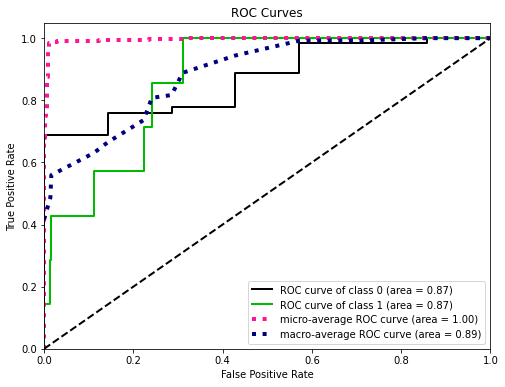

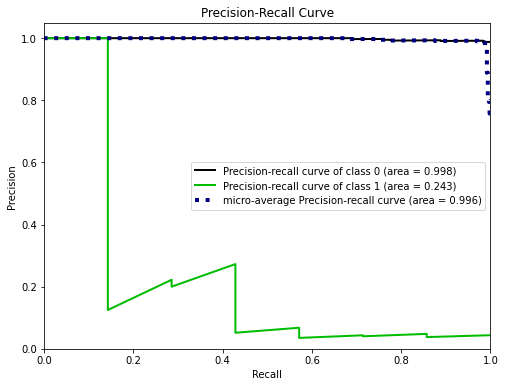

In [49]:
import scikitplot as skplt 
skplt.metrics.plot_roc(y_test, y_probas)
skplt.metrics.plot_precision_recall(y_test, y_probas)

Ks_2sampResult(statistic=1.0, pvalue=7.399507995628047e-300)


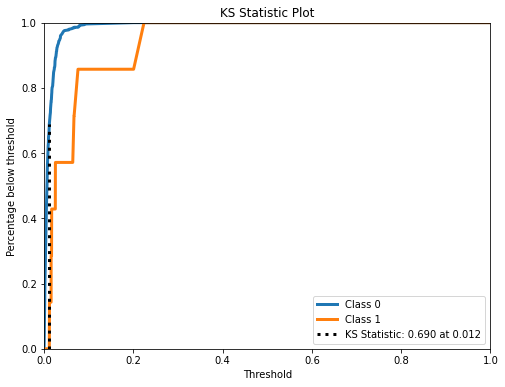

In [50]:
skplt.metrics.plot_ks_statistic(y_test, y_probas)

from scipy.stats import ks_2samp
print(ks_2samp(y_probas[:, 0], y_probas[:, 1]))

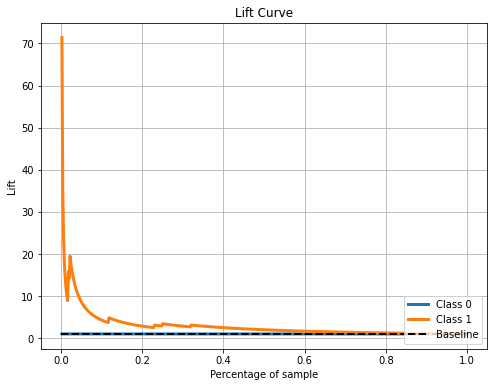

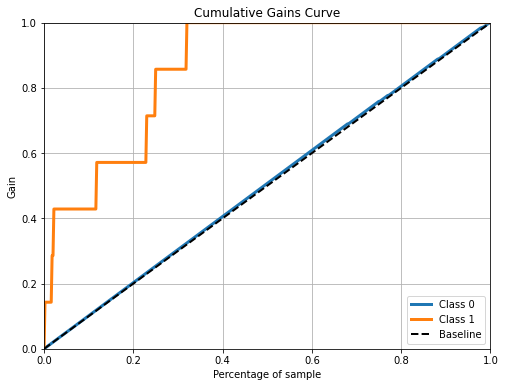

In [51]:
skplt.metrics.plot_lift_curve(y_test, y_probas); plt.show()
skplt.metrics.plot_cumulative_gain(y_test, y_probas)

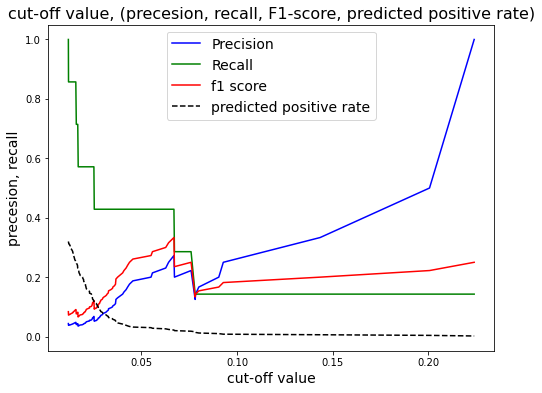

In [52]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probas[:, 1])
scores = [np.sum(to_labels(y_probas[:, 1], t))/len(y_probas[:, 1]) for t in thresholds]

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

### Brier score는 아주 낮음

In [53]:
metrics.brier_score_loss(y_test, y_probas[:, 1])

0.012787766344800349

## **2. 불균형데이터에 적합한 모형 평가지표**
- PR, MCC, Kohen Kappa

## matthews_corrcoef
- 예측 결과(predicted classes)와 실제 값(ground truth)과의 상관관계 Correlation between predicted classes and ground truth
- The MCC is in essence a correlation coefficient value between -1 and +1. 
- A coefficient of +1 represents a perfect prediction (FN=FP=0)
- 0 an average random prediction 
- -1 an inverse prediction.(TP=TN=0)
- The statistic is also known as the phi coefficient.
<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/33f3d62224f97cdef8bc559ee455c3f4815f5788'>

In [54]:
metrics.matthews_corrcoef(y_test, y_pred)

0.0

## cohen_kappa_score
- dummy classifier(random model) 보다 얼마나 더 잘 예측 을 하는지? 
- The kappa score (see docstring) is a number between -1 and 1.
- Scores above .8 are generally considered good agreement; zero or lower means no agreement (practically random labels).
<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/1a7a8f738ea187a60443bac93cd53b4d9d6b2231'>

In [55]:
metrics.cohen_kappa_score(y_test, y_pred)

0.0

## 학습곡선으로도 확인가능
**일반 예측 모형의 학습곡선 그림**

<img src='https://miro.medium.com/max/976/1*1of7faPDySjWq2ddfGARJA.jpeg'>

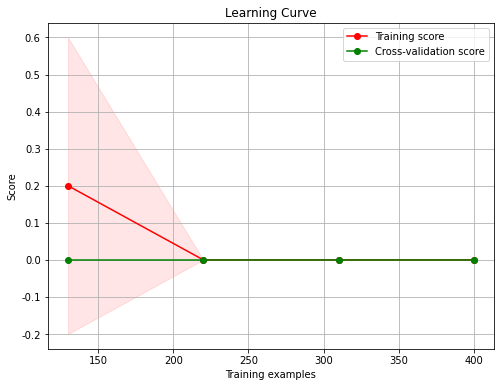

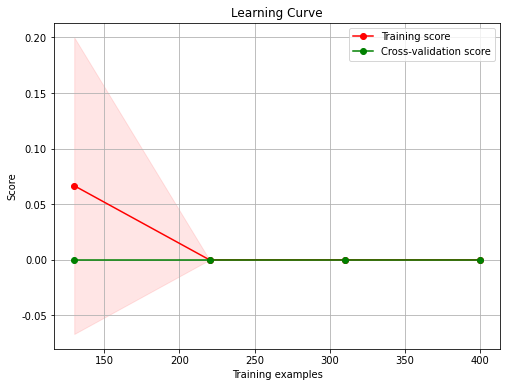

In [57]:
skplt.estimators.plot_learning_curve(clf, X_train, y_train, scoring='precision')
skplt.estimators.plot_learning_curve(clf, X_train, y_train, scoring='recall')

### 사이킷런 내부 모델의 의사결정임계값은 '0.5'로 예측 모델의 결과인 500개는 모두 음성으로 판정한 것을 확인할 수있으며 양성판정 비율은 모두 0.22 이하인 것으로 나타남

In [28]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Positive 판정 예측 확률 $P(y=1)$은 아주 낮음

Counter({0: 500})

Text(0.5, 1.0, 'DDistribution of probability of positive')

Text(0.5, 0, 'probability of positive')

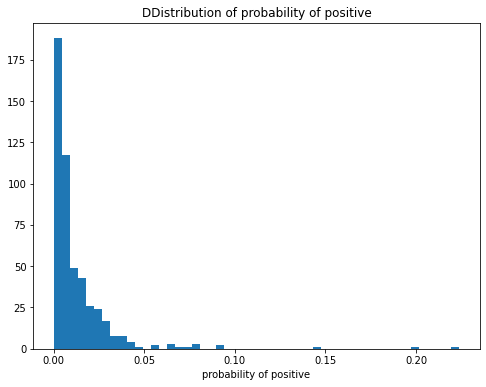

In [29]:
from collections import Counter
Counter(y_pred)
ax = plt.hist(y_probas[:, 1], bins=50)
plt.title('DDistribution of probability of positive'); plt.xlabel('probability of positive')

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


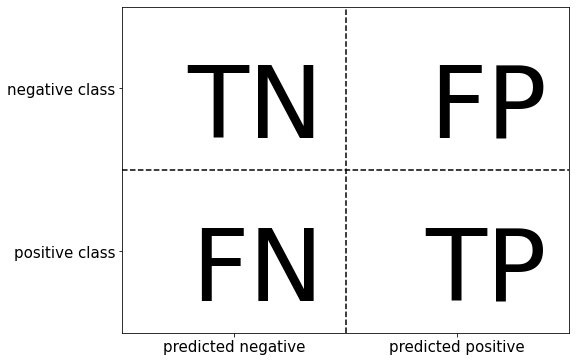

In [30]:
import mglearn
mglearn.plots.plot_binary_confusion_matrix()

- ROC와 PR curve는 다른 이야기를 하고 있으며 **불균형데이터의 예측 성능지표는 AUROC보다는 PR그래프가 우수**하다.
- **PR 그래프는 소수 범주 자료(양성, 1%)에 집중하는 반면 ROC curve는 음성과 양성 범주 자료를 모두 고려하기 때문이다**.

# <font color='blue'>**PR > ROC when Imbalanced data**
### 예를 들어 양성 10개 음성 100,000인 데이터의 예측 모형 A,B
- 예측모형 A : 900개를 양성으로 예측하였으나 9개만 실제 양성 
- 예측모형 B :  90개를 양성으로 예측하였으나 9개만 실제 양성
### 모델 B가 훨씬 정교하다(precise)
- 9/900(Model A precision)= 0.01 < 0.1= 9/90(Model B precision),  

### 반면에 
- 예측모형 A: TPR(recall) = 9/10 = 0.9,  FPR = (900–9)/100,000 = 0.00891
- 예측모형 B: TPR(recall) = 9/10 = 0.9,  FPR = (90–9)/100,000 = 0.00081

#### TPR(recall)은 예상대로 두 모델 간에 정확히 동일하지만, 
#### 불균형데이터(음성의 비중이 양성보다 훨씬 큼)에서의 FPR 차이(0.00891–0.00081 = 0.0081)는 거의 없어지게 되어
#### ROC는 true negative가 문제와 관련이 없다는 맥락에서  Model B의 우수한 성능을 반영할 수 없습니다.

### PR 곡선에서는
- 예측모형 A: recall = TPR = 0.9,  precision = 9/900 = 0.01
- 예측모형 B: recall = TPR = 0.9,  precision = 9/90 = 0.1

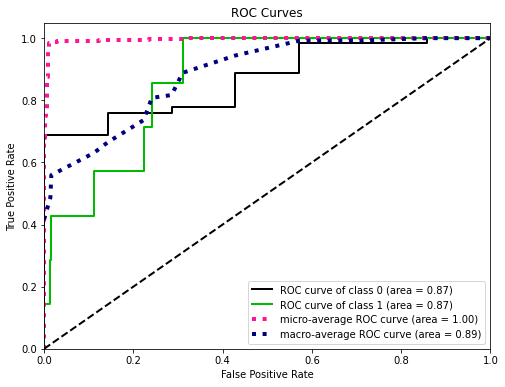

In [31]:
skplt.metrics.plot_roc(y_test, y_probas)

#**해결방안**
## **A. 손실함수 조정**

Dataset: Class 0(음성)= 985 개, Class1(양성)=15 개


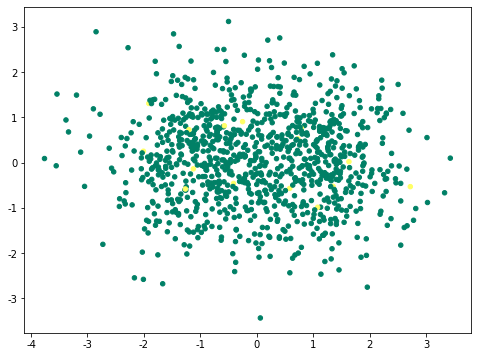

In [32]:
X, y = make_classification(n_samples=1000, n_classes=2, weights=[0.99, 0.01],
                          random_state=1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='summer')

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.5, 
                                                                    random_state = 2, stratify=y)
print(f'Dataset: Class 0(음성)= {len(y[y==0])} 개, Class1(양성)={len(y[y==1])} 개')

## 손실함수 조정 (예측오류에 차별적으로 Penalty를 부여)
<img src='https://i.stack.imgur.com/0rA2S.png' width=400>

$L= λ_1* −ylog(p)  − λ_2 ∗ (1−y)log(1−𝑝)$  
$λ_1, λ_2$ = 𝑝𝑒𝑛𝑎𝑙𝑡𝑦 

**$λ_1$ = 10, $λ_2$ =1**

**- FP는 10, FN는 1의 Penalty를 부여**

In [33]:
model = LogisticRegression(solver='lbfgs', class_weight='balanced')
params = {'C': np.logspace(-4, 4, 20), 'penalty': ['l1', 'l2']}
grid = model_selection.RandomizedSearchCV(model, params, cv=5, scoring= 'recall')
y_pred = grid.fit(X_train, y_train).predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.83      0.90       493
           1       0.06      0.71      0.10         7

    accuracy                           0.83       500
   macro avg       0.53      0.77      0.50       500
weighted avg       0.98      0.83      0.89       500



In [34]:
from sklearn.utils.class_weight import compute_class_weight
weight = compute_class_weight(class_weight = "balanced", 
                              classes= np.unique(y), 
                              y = y)
weight
_, count = np.unique(y, return_counts=True)
count
weight * count

array([ 0.50761421, 33.33333333])

array([985,  15])

array([500., 500.])

In [35]:
metrics.matthews_corrcoef(y_test, y_pred)

0.1657127573753248

In [36]:
model = LogisticRegression(solver='lbfgs', class_weight= {0:15, 1: 985})
params = {'C': np.logspace(-4, 4, 20), 'penalty': ['l1', 'l2']}
grid = model_selection.RandomizedSearchCV(model, params, cv=5, scoring= 'recall')
y_pred = grid.fit(X_train, y_train).predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       493
           1       0.05      0.71      0.10         7

    accuracy                           0.82       500
   macro avg       0.52      0.77      0.50       500
weighted avg       0.98      0.82      0.89       500



In [37]:
metrics.matthews_corrcoef(y_test, y_pred)

0.16307278828919597

array([1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,

Text(0.5, 1.0, 'DDistribution of probability of positive')

Text(0.5, 0, 'probability of positive')

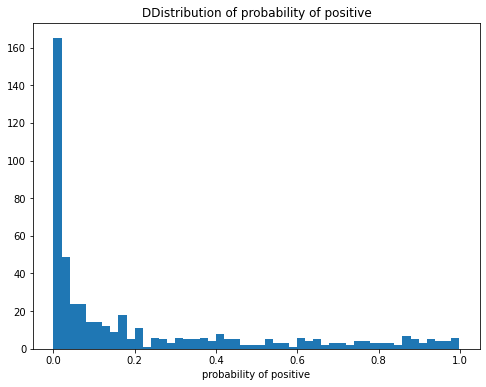

In [40]:
y_pred
y_probas = grid.predict_proba(X_test)
ax = plt.hist(y_probas[:, 1], bins=50)
plt.title('DDistribution of probability of positive'); plt.xlabel('probability of positive')

In [41]:
model = LogisticRegression(solver='lbfgs', class_weight= {0: 1, 1: 10})
params = {'C': np.logspace(-4, 4, 20), 'penalty': ['l1', 'l2']}
grid = model_selection.RandomizedSearchCV(model, params, cv=5, scoring= 'recall')
y_pred = grid.fit(X_train, y_train).predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       493
           1       0.20      0.29      0.24         7

    accuracy                           0.97       500
   macro avg       0.59      0.63      0.61       500
weighted avg       0.98      0.97      0.98       500



In [42]:
metrics.matthews_corrcoef(y_test, y_pred)

0.22615824684743635

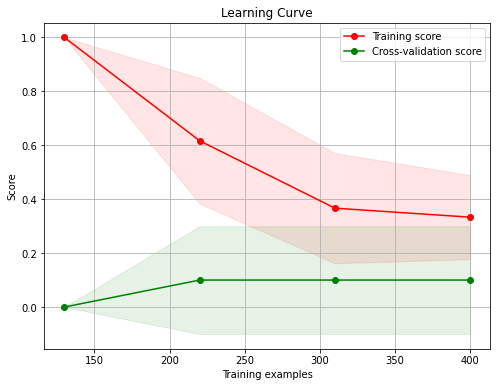

In [43]:
skplt.estimators.plot_learning_curve(model, X_train, y_train, scoring='recall')

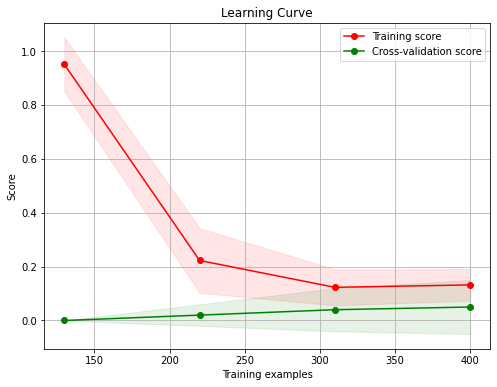

In [44]:
skplt.estimators.plot_learning_curve(model, X_train, y_train, scoring='precision')

###**불균형 데이터 해결 방안**
- Cost function penalization (class_balance weight)
- Change the performance metric :
    * Apply these F1 and recall scores
    * Kappa is a normalized classification accuracy by taking the class imbalance into consideration.
- Change the algorithm : 
    * Decision trees or boosting models frequently perform well on imbalanced data
    * Oversample minority, Undersample majority class, combined approach
- Miscellaneous
    * Collect more data
    * Treat the problem as anomaly detection; Isolation forests or autoencoders

# END